# Object Detection

**IoU** (Intersection over Union) is calculated as the area of overlap between two bounding boxes divided by the area of their union. 

$$ IoU = \frac{b_1 \cap b_2}{b_1 \cup b_2}, 0 \le IoU \le 1$$

While this is a good metric to evaluate object detection algorithms, it cannot be used as a loss function, because it is not differentiable when the boxes do not overlap.

To overcome this, the **GIoU** (Generalized-IoU) has been introduced

$$ GIoU = IoU - \frac{C - b_1 \cup b_2}{C} $$

It uses additionally the area of the smallest enclosing box ($C$) that contains both boxes, thus considering the relative positions of the boxes and solving the problem that non-overlapping bounding boxes have an $IoU=0$
If one box is completely inside the other, GIoU will degrade to IoU and experiments have shown that convergence can become difficult.

Next, **DIoU** (Distance-IOU)

$$ DIoU = IoU - \frac{\rho^2}{c^2} $$

**DIoU** considers the distance of the two bounding boxes ($\rho$) with respect to the enclosing box diagonal length ($c$) helping in convergence.

Finally, this has been extended to include the aspect ratio of the different bounding boxes, resulting in **CIoU** (Complete-IoU).

$$ CIoU = IoU - \frac{\rho^2}{c^2}-\alpha v $$

$\alpha v$ encapsulate the different aspect ratio of the bounding boxes.

In [123]:
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.patches as patches
import numpy as np
import jax.numpy as jnp
import jax
plt.rcParams["animation.html"] = "jshtml"

## Intersection over Union

In [124]:
def intersection(b1, b2):
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2
    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)
    return max(0, xB - xA) * max(0, yB - yA)


def union(b1, b2):
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2
    return w1 * h1 + w2 * h2 - intersection(b1, b2)


def iou(b1, b2):
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2
    return intersection(b1, b2) / union(b1, b2)

## Generalized Intersection over Union

In [125]:
def enclosement(b1, b2):
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2
    xA = min(x1, x2)
    yA = min(y1, y2)
    xB = max(x1 + w1, x2 + w2)
    yB = max(y1 + h1, y2 + h2)
    return (xB - xA) * (yB - yA)


def giou(b1, b2):
    R = (enclosement(b1, b2) - union(b1, b2)) / enclosement(b1, b2)
    return iou(b1, b2) - R

## Distance Intersection over Union

In [126]:
def distance(b1, b2):
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2
    center_b1 = (x1 + w1 / 2, y1 + h1 / 2)
    center_b2 = (x2 + w2 / 2, y2 + h2 / 2)
    x1, y1 = center_b1
    x2, y2 = center_b2
    return jnp.sqrt(jnp.square(x1 - x2) + jnp.square(y1 - y2))


def enclosing_box_diagonal(b1, b2):
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2

    xA = min(x1, x2)
    yA = min(y1, y2)
    xB = max(x1 + w1, x2 + w2)
    yB = max(y1 + h1, y2 + h2)
    return jnp.sqrt(jnp.square(xB - xA) + jnp.square(yB - yA))


def diou(b1, b2):
    R = jnp.square(distance(b1, b2))/jnp.square(enclosing_box_diagonal(b1, b2))
    return iou(b1, b2) - R

## Complete Intersection over Union

In [127]:
def ciou(b1, b2):
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2
    v = 4 * jnp.square(jnp.arctan(w1 / h1) -
                       jnp.arctan(w2 / h2)) / jnp.square(jnp.pi)
    alpha = v / (1 - iou(b1, b2) + v)
    R = v * alpha
    return diou(b1, b2) - R

## Evaluation

In [139]:
class MetricFn:
    def __init__(self, fn, name):
        self.fn = fn
        self.name = name

    def __call__(self, box, target_box):
        return self.fn(box, target_box)


class Sample:
    def __init__(self, box, target_box, metric_fn, axis):
        self.box = box
        self.target_box = target_box
        self.metric_fn = metric_fn
        self.boxes = [box]

        self.ax = axis
        self.ax.set_title(metric_fn.name)
        self.ax.set_xlim(0, 10)
        self.ax.set_ylim(0, 10)
        self.patch = patches.Rectangle(
            (box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
        self.target_patch = patches.Rectangle(
            (target_box[0], target_box[1]), target_box[2], target_box[3], linewidth=1, edgecolor='g', facecolor='none')
        self.ax.add_patch(self.patch)
        self.ax.add_patch(self.target_patch)

    def animate(self, t):
        if t < len(self.boxes):
            b = self.boxes[t]
            self.patch.set_width(b[2])
            self.patch.set_height(b[3])
            self.patch.set_xy((b[0], b[1]))
        return self.patch

    def evaluate(self):
        while self.metric_fn(self.box, self.target_box) < 0.9:
            gradient = jax.grad(
                lambda b: 1-self.metric_fn(b, self.target_box))(self.box)
            self.box -= 0.3 * gradient
            self.boxes.append(self.box)
            if jnp.isnan(jnp.sum(gradient)):
                print('grad is nan')
            if jnp.isnan(jnp.sum(gradient)) or jnp.sum(jnp.abs(gradient)) < 0.001:
                break
        return self.boxes


class Evaluator:
    def __init__(self, initial_boxes, target_box, metric_fns):
        self.fig, self.ax = plt.subplots(
            len(metric_fns), len(initial_boxes), figsize=(20, 20))
        self.samples = []

        if len(metric_fns) == 1 and len(initial_boxes) == 1:
            self.ax = np.array([[self.ax]])
        elif len(metric_fns) == 1:
            self.ax = self.ax.reshape(1, -1)
        elif len(initial_boxes) == 1:
            self.ax = self.ax.reshape(-1, 1)

        for i, metric_fn in enumerate(metric_fns):
            for j, initial_box in enumerate(initial_boxes):
                self.samples.append(
                    Sample(initial_box, target_box, metric_fn, self.ax[i, j]))

    def animate(self, t):
        return [sample.animate(t) for sample in self.samples]

    def evaluate(self):
        for sample in self.samples:
            sample.evaluate()
        maximum = max([len(sample.boxes) for sample in self.samples])
        return matplotlib.animation.FuncAnimation(self.fig, func=self.animate, frames=maximum, blit=True)

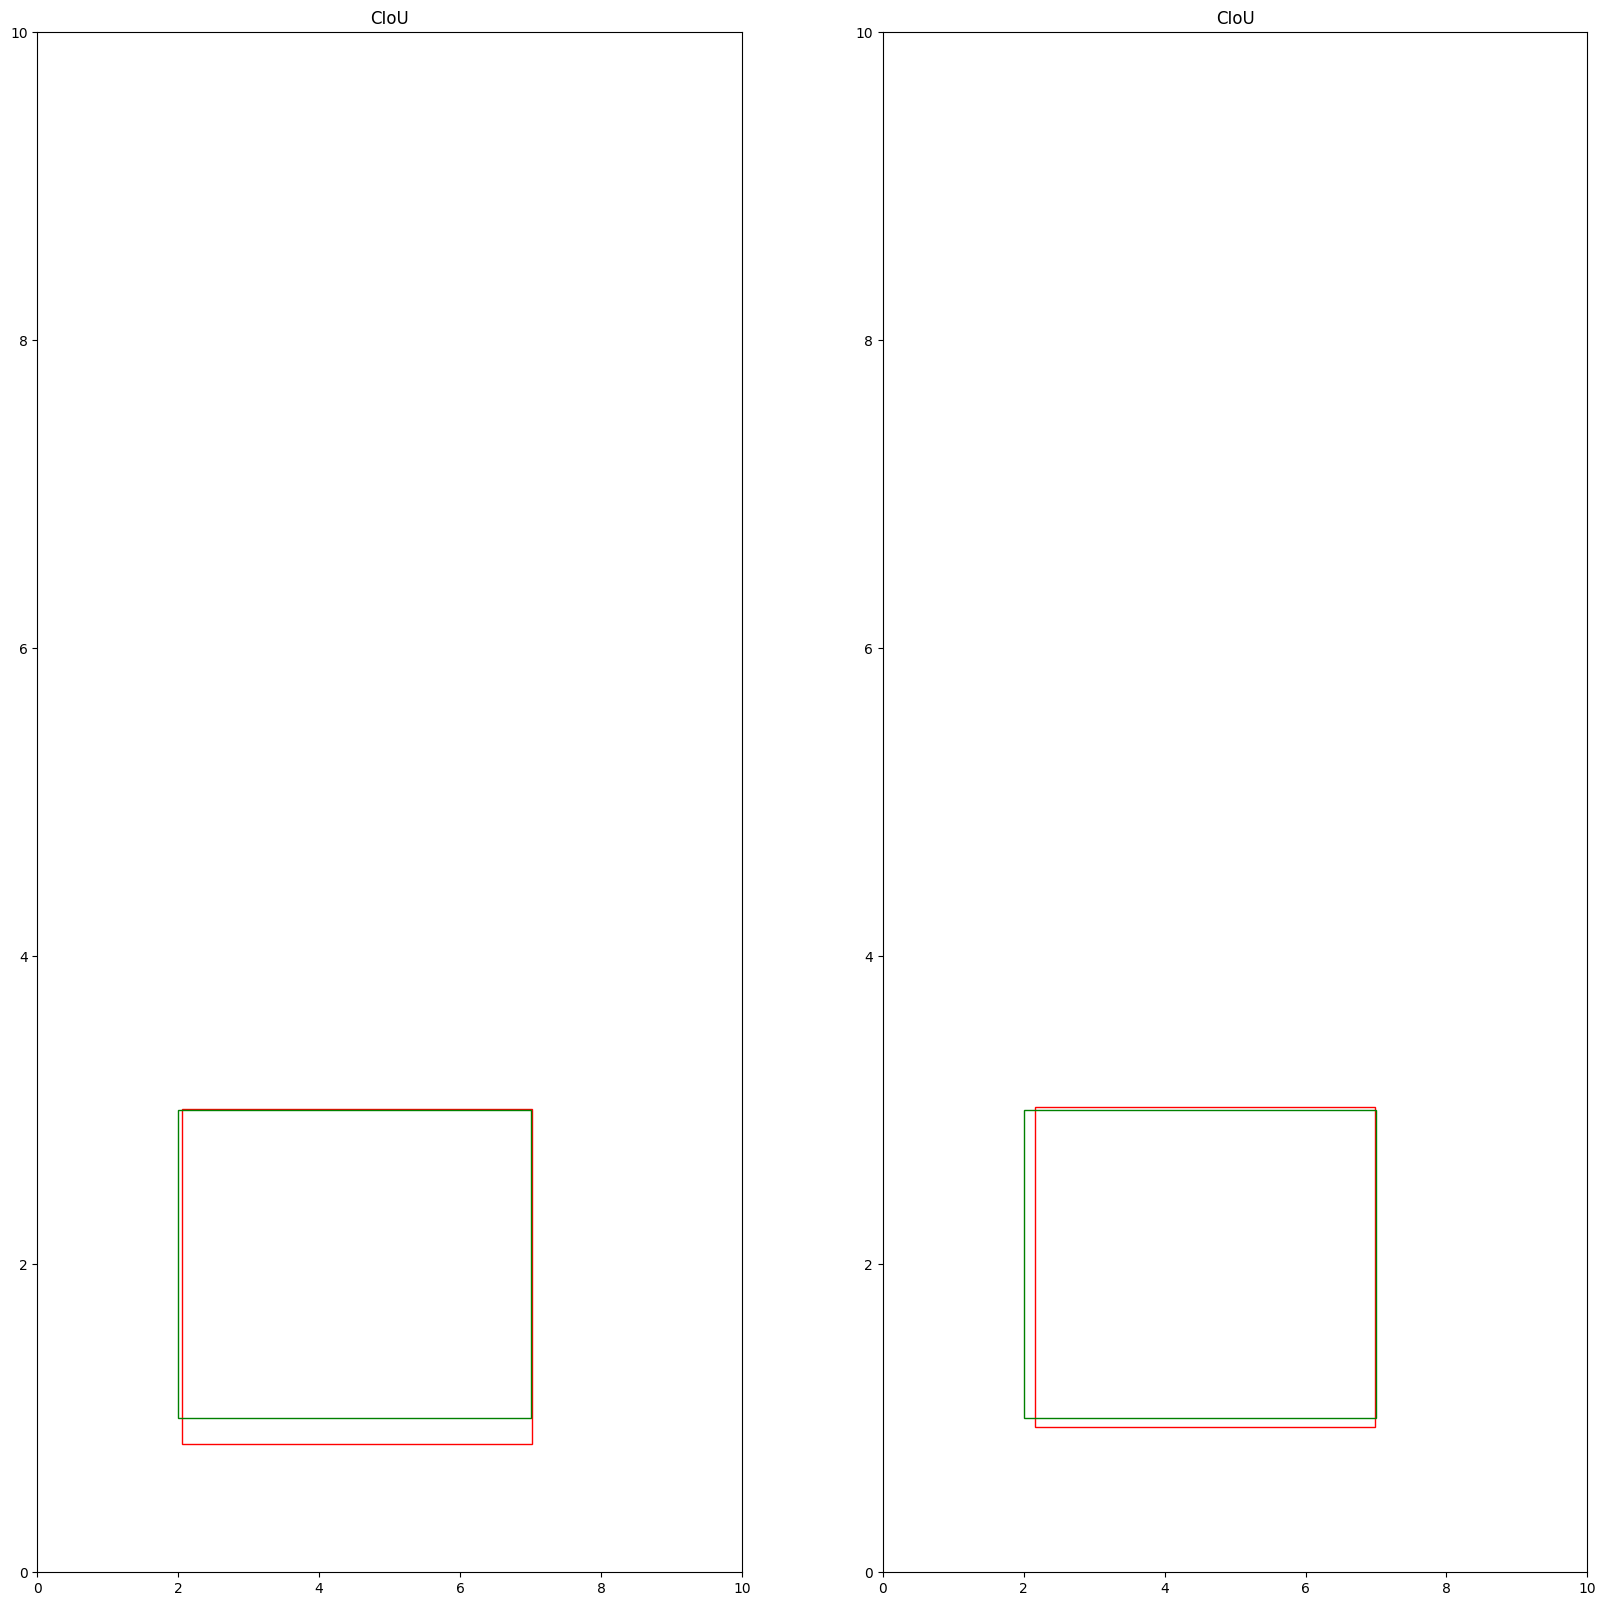

In [141]:
metric_fns = [
    MetricFn(iou, 'IoU'),
    MetricFn(giou, 'GIoU'),
    MetricFn(diou, 'DIoU'),
    MetricFn(ciou, 'CIoU'),
]

bb = [
    jnp.array([4, 6, 1, 1], dtype=jnp.float32),
    jnp.array([1, 2, 5, 5], dtype=jnp.float32),
    jnp.array([2, 1, 3, 1], dtype=jnp.float32)]

evaluator = Evaluator(bb, jnp.array([2, 1, 5, 2], dtype=jnp.float32), metric_fns)
evaluator.evaluate()

## Sources
* [Distance-IoU Loss: Faster and Better Learning for Bounding Box Regression](https://arxiv.org/pdf/1911.08287)